# Fit a single XGBoost model and calculate the SHAP values

**Research question: What is the relationship between the SHAP value and feature value?**

## Plain English summary

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values. This means that we can now turn these black box methods into transparent models and describe what the model used to obtain it's prediction.

SHAP values are calculated for each feature of each instance for a fitted model. In addition there is the SHAP base value which is the same value for all of the instances. The base value represents the models best guess for any instance without any extra knowledge about the instance (this can also be thought of as the "expected value"). It is possible to obtain the models prediction of an instance by taking the sum of the SHAP base value and each of the SHAP values for the features. This allows the prediction from a model to be transparant, and we can rank the features by their importance in determining the prediction for each instance.

In our previous notebook (03_xgb_combined_shap_key_features.ipynb) we looked at SHAP values for all the features (fitting models to k-fold data and comparing the differences of the SHAP values obtained across the 5 models). Here we will fit a single model to all of the data (no test set), calculate the SHAP values for this model and focus on understanding the relationship between the SHAP value and feature values for all of the features. We will also calculate the impact (in odds) that a change in feature value has on the likelihood of receiving thrombolysis.

SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

## Model and data

XGBoost model was trained on all of the data (no test set used). The 10 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Did the patient receive thrombolysis (0 = No, 1 = Yes)

## Aims

* Fit XGBoost model using feature data (no test set) to predict whether patient gets thrombolysis
* Calculate the SHAP values of the features
* Understand the relationship between SHAP values and feature values for each feature (using violin plots, histograms and descriptive text about the impact (in odds) that a change in feature value has on the likelihood of receiving thrombolysis)

## Observations
* Stroke type: The SHAP values for stroke type show that the model effectively eliminated any probability of receiving thrombolysis for non-ischaemic (haemorrhagic) stroke.
*  Arrival-to-scan time: The odds of receiving thrombolysis reduced by about 20 fold over the first 100 minutes of arrival to scan time.
* Stroke severity (NIHSS): The odds of receiving thrombolysis were lowest at NIHSS 0, increased and peaked at NIHSS 15-25, and then fell again with higher stroke severity (NIHSS above 25). The difference between minimum odds (at NIHSS 0) and maximum odds (at 15-25) of receiving thrombolysis was 30-35 fold.
* Stroke onset time type (precise vs. estimated): The odds of receiving thrombolysis were about 3 fold greater for precise onset time than estimated onset time.
* Disability level (mRS) before stroke: The odds of receiving thrombolysis fell about 5 fold between mRS 0 and 5.

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import machine learning methods
from xgboost import XGBClassifier

from os.path import exists

import shap

from scipy import stats

import os
import pickle
import json

# .floor and .ceil
import math

# So can take deep copy
import copy

## Set filenames

In [2]:
# Set up strings (describing the model) to use in filenames
number_of_features_to_use = 10
model_text = f'xgb_{number_of_features_to_use}_features'
notebook = '03a'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)   

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

For this exercise, we will fit a model using all of the data (rather than train/test splits used to assess accuracy). We will join up all of the test data (by definition, each instance exists only once across all of the 5 test sets)

In [5]:
data_loc = '../data/kfold_5fold/'

In [6]:
# Initialise empty list
test_data_kfold = []

# Read in the names of the selected features for the model
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# For each k-fold split
for i in range(5):
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=dict_feature_name, inplace=True)
    test_data_kfold.append(test)

# Join all the test sets. Set "ignore_index = True" to reset the index in the
#   new dataframe (to run from 0 to n-1), otherwise get duplicate index values
data = pd.concat(test_data_kfold, ignore_index=True)

## Get list of feature names

Before convert stroke team to one-hot encoded features.

In [7]:
feature_names = list(test_data_kfold[0])

## Edit data
### Divide into X (features) and y (labels)
We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (thrombolysis or not) `y`.

In [8]:
X = data.drop('Thrombolysis', axis=1)
y = data['Thrombolysis']

Average thromboylsis (this is the expected outcome of each patient, without knowing anything about the patient)

In [9]:
print (f'Average treatment: {round(y.mean(),2)}')

Average treatment: 0.3


### One-hot encode hospital feature

In [10]:
# Keep copy of original, with 'Stroke team' not one-hot encoded
X_combined = X.copy(deep=True)

# One-hot encode 'Stroke team'
X_hosp = pd.get_dummies(X['Stroke team'], prefix = 'team')
X = pd.concat([X, X_hosp], axis=1)
X.drop('Stroke team', axis=1, inplace=True)

### Get model feature names 
With one-hot encoded hospitals

In [11]:
# Get a list of the model feature names
feature_names_ohe = list(X.columns)

## Fit XGBoost model

An XGBoost model is trained on the full dataset (rather than train/test splits used to assess accuracy).

Use learning rate 0.5 to regularise the model. Increasing the learning rate value, increases the regularisation. Using a learning rate of 0.5 gives maximum variation between the hosptials. The default learning rate of 0.1 results in few differences between the hospitals (with eight of the one-hot encoded hospital features were not being used in the model - they each had a 0 SHAP value for all of the instances).

See https://samuel-book.github.io/samuel_shap_paper_1/xgb_with_feature_selection/91_learning_rate_optimisation.html?highlight=learning%20rate

In [12]:
filename = (f'./saved_models/{notebook}_{model_text}.p')
# Check if exists
file_exists = exists(filename)

if file_exists:
    # Load models
    with open(filename, 'rb') as filehandler:
        model = pickle.load(filehandler)
        
else:
    # Define and Fit model
    model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)
    model.fit(X, y)

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(model, filehandler)

# Get the predictions for each patient 
#   (the classification, and the probability of being in either class)
y_pred = model.predict(X)
y_pred_proba = model.predict_proba(X)

# Calculate the models accuracy
accuracy = np.mean(y == y_pred)
print(f'Model accuracy: {accuracy:0.3f}')

Model accuracy: 0.878


## SHAP values

SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios.

### Get SHAP values

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees. Once set up, we can use this explainer to calculate the SHAP values.

Either load from pickle (if file exists), or calculate.

Setup method to estimate SHAP values (in their default units: log odds)

In [13]:
%%time
# Set up method to estimate SHAP values for tree models and ensembles of trees

filename = f'./output/{notebook}_{model_text}_shap_explainer.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP explainer
    with open(filename, 'rb') as filehandler:
        explainer = pickle.load(filehandler)
else:
    # Set up method to estimate SHAP values for tree models & ensembles of trees
    explainer = shap.TreeExplainer(model)

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(explainer, filehandler)

CPU times: user 1.33 s, sys: 59.7 ms, total: 1.39 s
Wall time: 40.1 ms


Setup method to estimate SHAP values as a probability

In [14]:
%%time
# Set up method to estimate SHAP values for tree models and ensembles of trees    

filename = (f'./output/'
            f'{notebook}_{model_text}_shap_explainer_probability.p')
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        explainer_probability = pickle.load(filehandler)
else:
    explainer_probability = shap.TreeExplainer(model, X, 
                                               model_output='probability')

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(explainer_probability, filehandler)

CPU times: user 15 ms, sys: 202 µs, total: 15.2 ms
Wall time: 14.6 ms


Calculate the SHAP values

In [15]:
%%time
# Get/calculate SHAP values
filename = f'./output/{notebook}_{model_text}_shap_values_extended.p'
file_exists = exists(filename)

if file_exists:
    # Load explainer
    with open(filename, 'rb') as filehandler:
        shap_values_extended = pickle.load(filehandler)
else:
    # Get SHAP values
    shap_values_extended = explainer(X)
    
    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(shap_values_extended, filehandler)

CPU times: user 1.21 ms, sys: 75.9 ms, total: 77.1 ms
Wall time: 75.7 ms


The explainer returns the base value which is the same value for all instances [shap_value.base_values], the shap values per feature [shap_value.values]. It also returns the feature dataset values [shap_values.data]. You can (sometimes!) access the feature names from the explainer [explainer.data_feature_names].

Let's take a look at the data held for the first instance:
* .values has the SHAP value for each of the four features.
* .base_values has the best guess value without knowing anything about the instance.
* .data has each of the feature values

In [16]:
shap_values_extended[0]

.values =
array([ 7.56502628e-01,  4.88319576e-01,  1.10273695e+00,  4.40223962e-01,
        4.98975307e-01,  2.02812225e-01, -2.62601525e-01,  3.69181409e-02,
        2.30234995e-01,  3.20923195e-04, -6.03703642e-03, -7.17267860e-04,
        0.00000000e+00, -4.91688668e-04,  1.20360847e-03,  1.77788886e-03,
       -4.34198463e-03, -2.76021136e-04, -2.79896380e-03,  3.52182891e-03,
       -2.73969141e-04,  8.53505917e-03, -5.28220041e-03, -8.25227005e-04,
        6.20208494e-03,  6.92215608e-03, -6.32244349e-03, -3.35367222e-04,
        7.81939551e-03, -4.71850217e-06, -4.25534381e-05,  6.48253039e-03,
        8.43156071e-04, -6.28353562e-04, -1.25156669e-02, -7.92063680e-03,
       -1.99409085e-03, -5.05548809e-03, -3.90118686e-03,  1.30317558e-03,
        0.00000000e+00, -6.48246554e-04,  1.19629130e-03,  8.26304778e-04,
        1.28053436e-02,  2.55714403e-03, -3.20375757e-03,  4.23251512e-03,
       -7.19791185e-03,  4.02670400e-03,  3.75146419e-03,  8.31848301e-04,
        3.45067

There is one of these for each instance.

In [17]:
shap_values_extended.shape

(88792, 141)

#### Calculate average SHAP values for each feature (across all the patients)

Calculate the mean SHAP value for each feature (across all instances), in three ways:
* mean of raw values
* mean of absolute values
* absolute of mean of raw values

(Will use mean |SHAP| to rank the features to determine the order of features for the violin plots)

In [18]:
# Get SHAP values
shap_values = shap_values_extended.values

# Calculate mean SHAP value for each feature (across all instances)
df_shap_values_mean = pd.DataFrame(index=feature_names_ohe)
df_shap_values_mean['mean_shap'] = np.mean(shap_values, axis=0)
df_shap_values_mean['abs_mean_shap'] = np.abs(df_shap_values_mean['mean_shap'])
df_shap_values_mean['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
df_shap_values_mean['rank'] = df_shap_values_mean['mean_abs_shap'].rank(
    ascending=False).values
df_shap_values_mean.sort_values('rank', inplace=True, ascending=True)
df_shap_values_mean.head(10)

,mean_shap,abs_mean_shap,mean_abs_shap,rank
Infarction,-0.974695,0.974695,1.540489,1.0
Arrival-to-scan time,-0.385795,0.385795,0.991457,2.0
Stroke severity,-0.196834,0.196834,0.915676,3.0
Precise onset time,-0.061659,0.061659,0.538988,4.0
Prior disability level,-0.005883,0.005883,0.387559,5.0
Use of AF anticoagulants,-0.041382,0.041382,0.310106,6.0
Onset-to-arrival time,-0.066359,0.066359,0.291748,7.0
Age,-0.014048,0.014048,0.167593,8.0
Onset during sleep,-0.024299,0.024299,0.102481,9.0
team_VKKDD9172T,-0.005500,0.005500,0.029842,10.0


Take order of the first 9 features (assuming that all of the teams one-hot encoded features are ranked below the other features).

In [19]:
features_shap_ranked = list(df_shap_values_mean.head(9).index)

### Violin plots show the relationship between feature value and SHAP value for all of the features

Output descriptive text to use in the paper to describe the differences a feature value had on the likelihood of receiving thromboylsis.

Resource: 
https://towardsdatascience.com/binning-records-on-a-continuous-variable-with-pandas-cut-and-qcut-5d7c8e11d7b0
https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html

In [20]:
def set_ax(ax, category_list, feat, rotation=0):
    '''
    ax [matplotlib axis object] = matplotlib axis object
    category_list [list] = used for the xtick labels (the grouping of the data)
    feat [string] = used in the axis label, the feature that is being plotted
    rotation [integer] = xtick label rotation

    reeturn [matplotlib axis object]
    
    resource: 
    https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html
    '''
    # Set the axes ranges and axes labels
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=rotation, fontsize=10)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(f'SHAP values for {feat}', fontsize=12)
    ax.set_xlabel(f'Feature values for {feat}', fontsize=12)
    return(ax)

Create violin plot and descriptive text

Stroke type: The SHAP values for stroke type show that the 
model effectively eliminated any probability of receiving 
thrombolysis for non-ischaemic (haemorrhagic) stroke. The 
odds of receiving thrombolysis fell about 6402.03 
fold.

Arrival-to-scan time: The odds of receiving thrombolysis reduced by 
about 9.68 (20) fold over the first 120 minutes of arrival to scan time.

Stroke severity (NIHSS): The odds of receiving thrombolysis were lowest
 at NIHSS 0, increased and peaked at NIHSS 15-25, and then fell again 
with higher stroke severity (NIHSS above 25). The difference between 
minimum odds (at NIHSS 0) and maximum odds (at 15-25) of receiving 
thrombolysis was 26.69 (30-35) fold.

Stroke onset time type (precise vs. estimated): The odds of receiving 
thrombolysis were about 3.24 (3) fold greater for precise onset time than 
estimated onset time.

Disability level (mRS) before stroke: The odds of receiving 
thrombolysis fell about 6.48 (5) fold between mRS 0 and 5.

Use of AF an

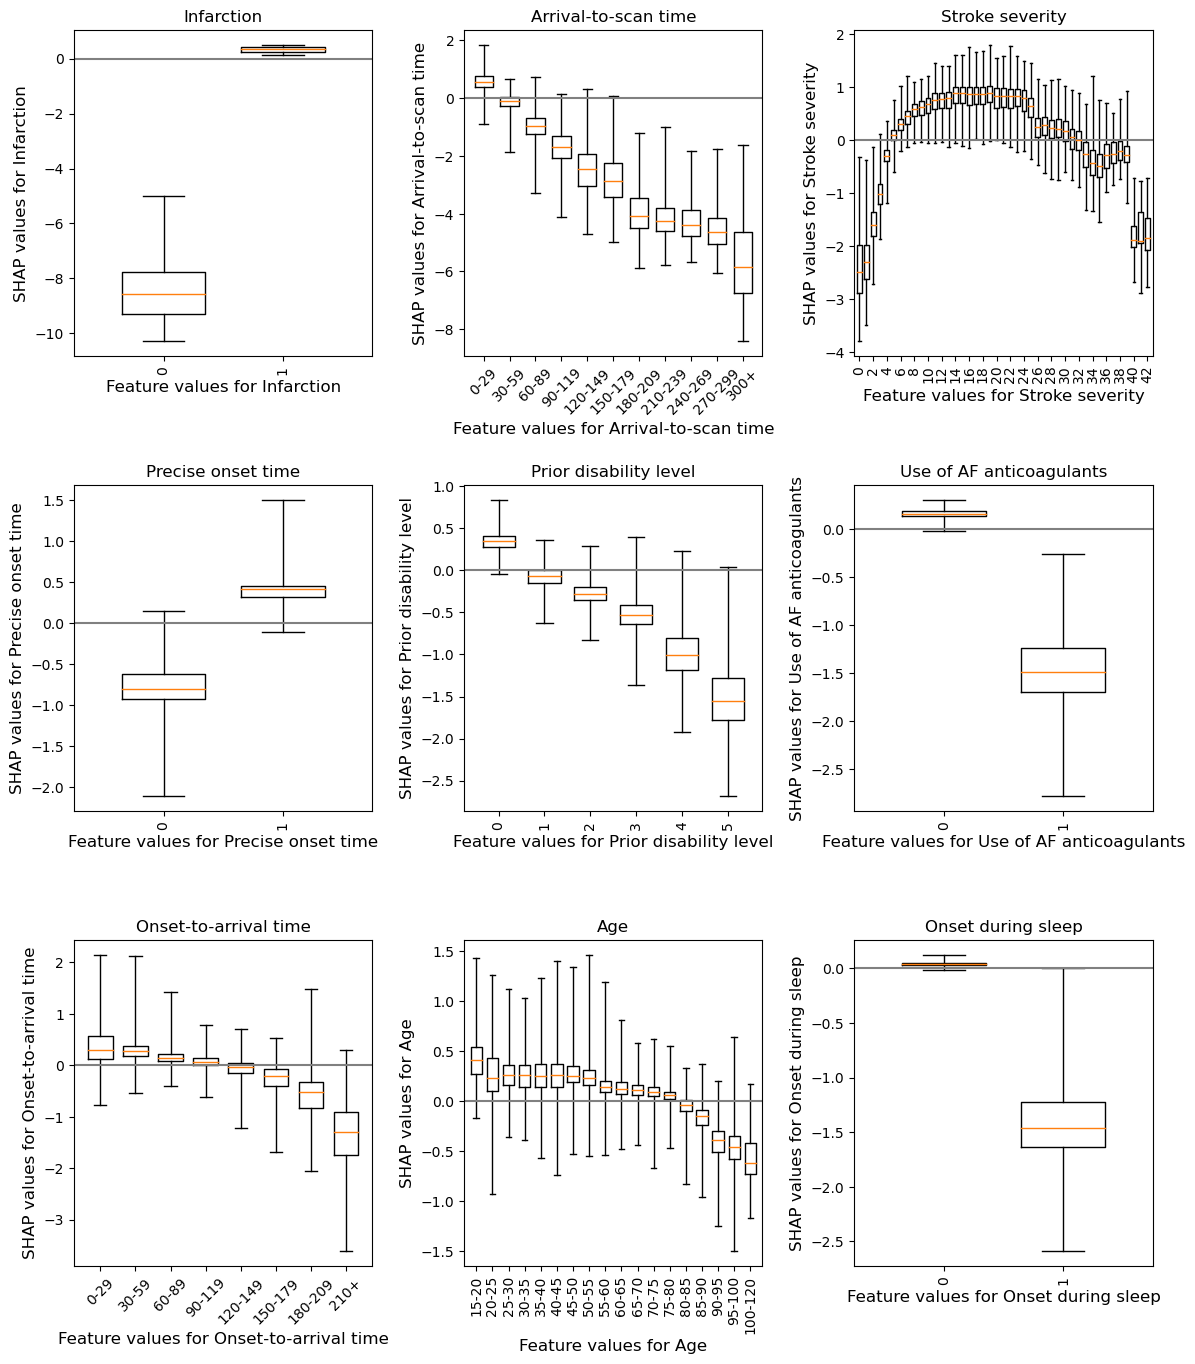

In [21]:
# Feature Age needs special consideration. It needs the x ticks to be created,
# as the other features with over 50 unique values, but age is already grouped 
# for the model (into 5yr groups) and so is treated as the other type.

# Create figure
fig = plt.figure(figsize=(12,14), constrained_layout=True)
# A subplot showing violin plot for each feature.
# First prepare the fature data for the violin plot: if feature has more than 
# 50 unique values then assume it needs to be binned (a violin for each bin)

# Determine number of rows of subplots by rounding up
nrows = math.ceil(len(features_shap_ranked)/4)

# Through each feature
for n, feat in enumerate(features_shap_ranked):    
    
    # Get data adn SHAP values
    feature_data = shap_values_extended[:, feat].data
    feature_shap = shap_values_extended[:, feat].values

    # If feature has more that 50 unique values, then assume it needs to be 
    # binned (otherwise assume they are unique categories)
    if np.unique(feature_data).shape[0] > 50:
        # bin the data, create a violin per bin
        
        # settings for the plot
        rotation = 45
        step = 30
        n_bins = min(11, np.int((feature_data.max())/step))
        
        # create list of bin values
        bin_list = [(i*step) for i in range(n_bins)]
        bin_list.append(feature_data.max())

        # create list of bins (the unique categories)
        category_list = [f'{i*step}-{((i+1)*step-1)}' for i in range(n_bins-1)]
        category_list.append(f'{(n_bins-1)*step}+')

        # bin the feature data
        feature_data = pd.cut(feature_data, bin_list, labels=category_list, 
                              right=False)

    else:
        # create a violin per unique value
        
        # settings for the plot
        rotation = 90
        
        # create list of unique categories in the feature data
        # Age needs to keep its decimal value (midpoint between 5 yrs)
        category_list = np.unique(feature_data)
        if feat != 'Age':
            category_list = [int(i) for i in category_list]

    # create a list, each entry contains the corresponsing SHAP value for that 
    # category (or bin). A violin will represent each list.    
    shap_per_category = []
    for category in category_list:
        mask = feature_data == category
        shap_per_category.append(feature_shap[mask])

    # Output descriptive text to use in the paper to describe the differences a 
    # feature value had on the likelihood of receiving thromboylsis.
    if feat == "Infarction":
        range_shap_log_odds = np.mean(shap_per_category[1]) - np.mean(shap_per_category[0])
        odds = math.exp(range_shap_log_odds)
        print(f"Stroke type: The SHAP values for stroke type show that the \n"
              f"model effectively eliminated any probability of receiving \n"
              f"thrombolysis for non-ischaemic (haemorrhagic) stroke. The \n"
              f"odds of receiving thrombolysis fell about {round(odds,2)} \n"
              f"fold.\n")    
    if feat == "Arrival-to-scan time":
        range_shap_log_odds = np.mean(shap_per_category[0]) - np.mean(shap_per_category[3])
        odds = math.exp(range_shap_log_odds)
        print(f"Arrival-to-scan time: The odds of receiving thrombolysis reduced by \n"
        f"about {round(odds,2)} (20) fold over the first 120 minutes of arrival to scan time.\n")    
    if feat == "Stroke severity":
        range_shap_log_odds = np.mean(shap_per_category[19]) - np.mean(shap_per_category[0])
        odds = math.exp(range_shap_log_odds)
        print(f"Stroke severity (NIHSS): The odds of receiving thrombolysis were lowest\n"
          f" at NIHSS 0, increased and peaked at NIHSS 15-25, and then fell again \n"
          f"with higher stroke severity (NIHSS above 25). The difference between \n"
          f"minimum odds (at NIHSS 0) and maximum odds (at 15-25) of receiving \n"
          f"thrombolysis was {round(odds,2)} (30-35) fold.\n")
    if feat == "Precise onset time":
        range_shap_log_odds = np.mean(shap_per_category[1]) - np.mean(shap_per_category[0])
        odds = math.exp(range_shap_log_odds)
        print(f"Stroke onset time type (precise vs. estimated): The odds of receiving \n"
          f"thrombolysis were about {round(odds,2)} (3) fold greater for precise onset time than \n"
          f"estimated onset time.\n")
    if feat == "Prior disability level":
        range_shap_log_odds = np.mean(shap_per_category[0]) - np.mean(shap_per_category[5])
        odds = math.exp(range_shap_log_odds)
        print(f"Disability level (mRS) before stroke: The odds of receiving \n"
        f"thrombolysis fell about {round(odds,2)} (5) fold between mRS 0 and 5.\n")
    if feat == "Use of AF anticoagulants":
        range_shap_log_odds = np.mean(shap_per_category[0]) - np.mean(shap_per_category[1])
        odds = math.exp(range_shap_log_odds)
        print(f"Use of AF anticoagulants: The odds of receiving thrombolysis were about\n"
        f" {round(odds,2)} fold greater for no use.\n")
    if feat == "Onset-to-arrival time":
        range_shap_log_odds = np.mean(shap_per_category[4]) - np.mean(shap_per_category[7])
        odds = math.exp(range_shap_log_odds)
        print(f"Onset-to-arrival time: The odds of receiving thrombolysis were similar \n"
        f"below 120 minutes, then fell about {round(odds,2)} fold between 120 and above.\n")
    if feat == "Age":
        range_shap_log_odds = np.mean(shap_per_category[13]) - np.mean(shap_per_category[17])
        odds = math.exp(range_shap_log_odds)
        print(f"Age: The odds of receiving thrombolysis were similar below 80 years \n"
        f"old, then fell about {round(odds,2)} fold between 80 and 120 years old.\n")
    if feat == "Onset during sleep":
        range_shap_log_odds = np.mean(shap_per_category[0]) - np.mean(shap_per_category[1])
        odds = math.exp(range_shap_log_odds)
        print(f"Onset during sleep: The odds of receiving thrombolysis were about \n"
        f"{round(odds,2)} fold lower for onset during sleep.\n")

    if feat == 'Age':
        # create text of x ticks
        category_list = [f'{int(i-2.5)}-{int(i+2.5)}' for i in category_list]

        # SSNAP dataset had oldest age category as 100-120 (not a 5 yr band as 
        #   the other ages). To accommodate this, if last age category is "110"
        #   then overwrite the label with the correct band (100-120), and not
        #   107-112 as the above code would create.
        if category_list[-1] == '107-112':
            category_list[-1] = '100-120'
            
    # create violin plot
    ax = fig.add_subplot(nrows,3,n+1)
    
    ax.boxplot(shap_per_category, whis=99999, widths=0.7)
    
    # Add line at Shap = 0
    feature_values = shap_values_extended[:, feat].data
    ax.plot([0, len(feature_values)], [0,0],c='0.5')   

    # customise the axes
    ax = set_ax(ax, category_list, feat, rotation=rotation)
    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    
    # Adjust stroke severity tickmarks
    if feat == 'Stroke severity':
        ax.set_xticks(np.arange(1, len(category_list)+1, 2))
        ax.set_xticklabels(category_list[0::2])   
    
    # Add title
    ax.set_title(feat)
    
plt.tight_layout(pad=2)
    
fig.savefig(f'output/{notebook}_{model_text}_thrombolysis_shap_boxplot_all_'
            f'features.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)

plt.show()

### Compare SHAP values for the hospital one-hot encoded features

The hospital feature is one-hot encoded, so there is a SHAP value per stroke team. We will use this to create a histogram of the frequency of the SHAP value for the hospital feature (take the mean of the SHAP values for the instances for each hospital's own patients).

In [22]:
# Set up list for storing patient data and hospital SHAP
feature_data_with_shap = []

# Get mean SHAP for stroke team when patient attending that stroke team
unique_stroketeams_list = list(np.unique(data['Stroke team']))
stroke_team_mean_shap = []
# Loop through stroke teams
for stroke_team in unique_stroketeams_list:
    # Identify rows in test data that match each stroke team
    mask = data['Stroke team'] == stroke_team
    stroke_team_shap_all_features = shap_values[mask]
    # Get column index for stroke_team_in_shap
    feature_name = 'team_' + stroke_team
    index = feature_names_ohe.index(feature_name)
    # Get SHAP values for hospital
    stroke_team_shap = stroke_team_shap_all_features[:, index]
    # Get mean
    mean_shap = np.mean(stroke_team_shap)
    # Store mean
    stroke_team_mean_shap.append(mean_shap)
    # Get and store feature data and add SHAP
    feature_data = data[mask]
    feature_data['Hospital_SHAP'] = stroke_team_shap
    feature_data_with_shap.append(feature_data)

# Concatenate and save feature_data_with_shap
feature_data_with_shap = pd.concat(feature_data_with_shap, axis=0)
feature_data_with_shap.to_csv(
   f'./predictions/{notebook}_{model_text}_feature_data_with_hospital_shap.csv', 
    index=False)

# Create and save shap mean value per hospital
hospital_data = pd.DataFrame()
hospital_data["stroke_team"] = unique_stroketeams_list
hospital_data["shap_mean"] = stroke_team_mean_shap
hospital_data.to_csv(
    f'./predictions/{notebook}_{model_text}_mean_shap_per_hospital.csv', 
    index=False)

In [23]:
hospital_data

,stroke_team,shap_mean
0,AGNOF1041H,-0.026516
1,AKCGO9726K,0.520501
2,AOBTM3098N,-0.401549
3,APXEE8191H,0.000000
4,ATDID5461S,0.182610
...,...,...
127,YPKYH1768F,-0.166696
128,YQMZV4284N,0.388534
129,ZBVSO0975W,-0.573069
130,ZHCLE1578P,0.139613


#### Plot histogram using color scheme from violin plots
* facecolor = [0.12156863, 0.46666667, 0.70588235, 0.3]
* edgecolor= [0.12156863, 0.46666667, 0.70588235, 1.]

Plot histogram of the frequency of the mean SHAP value for the instances for each hospital's own patients

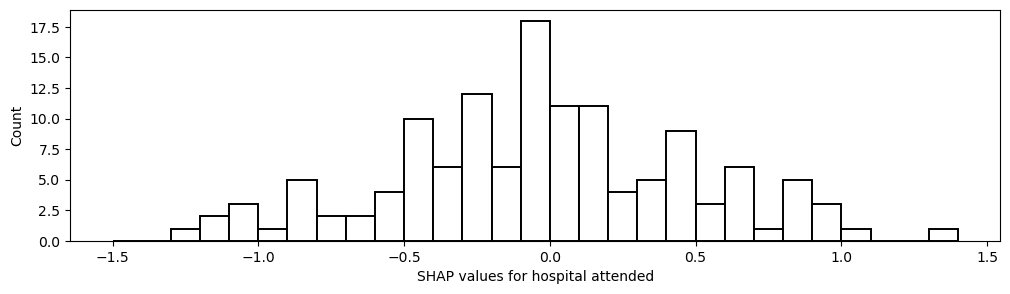

In [24]:
# Plot histogram
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot()

ax.hist(stroke_team_mean_shap, bins=np.arange(-1.5, 1.5, 0.1), 
        color='w', ec='k', linewidth=1.4)

ax.set_xlabel('SHAP values for hospital attended')
ax.set_ylabel('Count')
plt.savefig(f'./output/{notebook}_{model_text}_hosp_shap_hist.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

Output descriptive text to use in the paper to describe the differences the hospitalfeature value had on the likelihood of receiving thromboylsis.
Convert from log odds to odds.

In [25]:
range_shap_log_odds = max(stroke_team_mean_shap) - min(stroke_team_mean_shap)
odds = math.exp(range_shap_log_odds)
print(f"There was a {round(odds,2)} fold difference in odds of receiving thrombolysis between hospitals")

There was a 13.6 fold difference in odds of receiving thrombolysis between hospitals


### Pass all patients through all hospital models to calculate their thrombolysis rate

For each hospital, set all of the 10k patients in the test set as attending that hospital, and calculate the thrombolysis rate. This will give a thrombolysis rate for each hospital with patient variation removed, and only hospital factors remaining.

In [26]:
# Get list of hospital names
hospitals = list(set(data['Stroke team']))
hospitals.sort()

# Initiate lists
thrombolysis_rate = []
single_predictions = []


# One hot encode hospitals (test set)
X_test_hosp = pd.get_dummies(data['Stroke team'], prefix = 'team')

# For each hospital
for hospital in hospitals:
    
    # Get test data without thrombolysis hospital or stroke team
    X_test_no_hosp = data.drop(['Thrombolysis', 'Stroke team'], axis=1)
    
    # Copy hospital dataframe and change hospital ID (after setting all to zero)
    X_test_adjusted_hospital = X_test_hosp.copy()
    X_test_adjusted_hospital.loc[:,:] = 0
    team = "team_" + hospital
    X_test_adjusted_hospital[team] = 1
    
    X_test_adjusted = pd.concat(
        [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
    
    # Get predicted probabilities and class
    y_prob = model.predict_proba(X_test_adjusted)[:,1]
    y_pred = model.predict(X_test_adjusted)
    thrombolysis_rate.append(y_pred.mean())
    
    # Save predictions
    single_predictions.append(y_pred * 1)

In [27]:
# Convert individual predictions (a list of arrays) to a NumPy array, and 
#   transpose
patient_results = np.array(single_predictions).T

# Convert to DataFrame
patient_results = pd.DataFrame(patient_results)

# And save as file
patient_results.to_csv(f'./output/{notebook}_{model_text}_individual_'
                       f'predictions.csv', 
                       index=False)